# 04__results

in this notebook, i aggregate results from CRISPhieRmix and plot.

figures in this notebook:
- Fig 3F: plot showing transcript-level enrichments vs. CRISPhieRmix FDR

supplemental tables in this notebook:
- Table S3: enrichment scores & FDRs for all targeted TSSs

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from ast import literal_eval
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

## variables

In [3]:
data_filt_f = "../../../data/02__screen/02__enrichment_data/data_filt.with_batch.tmp"

In [4]:
crisphie_diff_f = "../../../data/02__screen/02__enrichment_data/CRISPhieRmix_diff.with_batch.txt"

In [5]:
crisphie_dz_f = "../../../data/02__screen/02__enrichment_data/CRISPhieRmix_dz.with_batch.txt"

In [6]:
## liu results
liu_res_f = "../../../misc/11__liu_data/iPSC_results.txt"
liu_meta_f = "../../../misc/11__liu_data/tss_metadata.txt"

## 1. import data

In [7]:
data_filt = pd.read_table(data_filt_f, sep="\t")
data_filt.head()

,sgRNA,ctrl_status,gene_id,gene_name,transcript_id,transcript_name,transcript_biotype_status,tss_chr_hg38,tss_start_hg38,tss_strand_hg38,...,padj_diff,baseMean_dz,raw_l2fc_dz,l2fc_dz,l2fcSE_dz,stat_dz,pvalue_dz,padj_dz,sgRNA_filt,group_id_rd
0,GGGAAGTGAGATGACGGTCG,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,0.942053,1819.659953,-0.101521,0.115301,0.157254,-0.645588,0.518546,0.821536,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...
1,GGAAGTGAGATGACGGTCGC,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,0.764159,1860.512015,-0.009595,0.011037,0.160428,-0.059808,0.952309,0.987223,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...
2,GAAGTGAGATGACGGTCGCG,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,0.960657,1276.156392,0.148680,-0.177984,0.182743,0.813605,0.415872,0.763113,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...
3,CCCTGAAAAACTTGTGCCCT,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,0.716573,3147.410238,0.077058,-0.083245,0.127034,0.606589,0.544124,0.831248,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...
4,CTGCCGGGGAAGTGAGATGA,experimental,ENSG00000224616.1_1,RTCA-AS1,ENST00000421185.1_1,RTCA-AS1-001,promoter_overlap,chr1,100266115,-,...,0.813933,1264.364390,-0.194712,0.231841,0.177354,-1.097870,0.272261,0.655162,8.0,RTCA-AS1-001;;;NC_000001.11:-:100266115;;;expe...


In [8]:
crisphie_diff = pd.read_table(crisphie_diff_f, sep="\t")
len(crisphie_diff)

9771

In [9]:
crisphie_dz = pd.read_table(crisphie_dz_f, sep="\t")
len(crisphie_dz)

10480

## 2. parse results from CRISPhieRmix

In [10]:
# if using gene level to group
# crisphie["gene_name"] = crisphie["groups"].str.split("__", expand=True)[0]
# crisphie["ctrl_status_fixed"] = crisphie["groups"].str.split("__", expand=True)[1]

# if using transcript level
crisphie_diff["transcript_name"] = crisphie_diff["groups"].str.split(";;;", expand=True)[0]
crisphie_diff["group_id"] = crisphie_diff["groups"].str.split(";;;", expand=True)[1]
crisphie_diff["ctrl_status"] = crisphie_diff["groups"].str.split(";;;", expand=True)[2]
crisphie_diff["transcript_biotype_status"] = crisphie_diff["groups"].str.split(";;;", expand=True)[3]
crisphie_diff["n_sgRNA"] = crisphie_diff["groups"].str.split(";;;", expand=True)[4].astype(int)
crisphie_diff.head()

,groups,FDR,transcript_name,group_id,ctrl_status,transcript_biotype_status,n_sgRNA
0,"[A1BG-AS1-006, A1BG-AS1-005, A1BG-AS1-002];;;N...",0.814892,"[A1BG-AS1-006, A1BG-AS1-005, A1BG-AS1-002]",NC_000019.10:+:58347754,experimental,promoter_overlap,3
1,"[ABCA9-AS1-006, ABCA9-AS1-002];;;NC_000017.11:...",0.975769,"[ABCA9-AS1-006, ABCA9-AS1-002]",NC_000017.11:+:69012346,experimental,transcript_overlap,7
2,"[AC002456.2-001, AC002456.2-002];;;NC_000007.1...",0.975997,"[AC002456.2-001, AC002456.2-002]",NC_000007.14:-:90595884,experimental,promoter_overlap,6
3,"[AC004237.1-002, AC004237.1-004, AC004237.1-00...",0.565542,"[AC004237.1-002, AC004237.1-004, AC004237.1-003]",NC_000005.10:+:132689724,experimental,transcript_overlap,4
4,"[AC004448.5-001, AC004448.5-003];;;NC_000017.1...",0.969973,"[AC004448.5-001, AC004448.5-003]",NC_000017.11:-:19460959,experimental,transcript_overlap,5


In [11]:
# if using transcript level
crisphie_dz["transcript_name"] = crisphie_dz["groups"].str.split(";;;", expand=True)[0]
crisphie_dz["group_id"] = crisphie_dz["groups"].str.split(";;;", expand=True)[1]
crisphie_dz["ctrl_status"] = crisphie_dz["groups"].str.split(";;;", expand=True)[2]
crisphie_dz["transcript_biotype_status"] = crisphie_dz["groups"].str.split(";;;", expand=True)[3]
crisphie_dz["n_sgRNA"] = crisphie_dz["groups"].str.split(";;;", expand=True)[4].astype(int)
crisphie_dz.head()

,groups,FDR,transcript_name,group_id,ctrl_status,transcript_biotype_status,n_sgRNA
0,"[A1BG-AS1-006, A1BG-AS1-005, A1BG-AS1-002];;;N...",0.610012,"[A1BG-AS1-006, A1BG-AS1-005, A1BG-AS1-002]",NC_000019.10:+:58347754,experimental,promoter_overlap,6
1,"[ABCA9-AS1-006, ABCA9-AS1-002];;;NC_000017.11:...",0.861034,"[ABCA9-AS1-006, ABCA9-AS1-002]",NC_000017.11:+:69012346,experimental,transcript_overlap,9
2,"[AC002456.2-001, AC002456.2-002];;;NC_000007.1...",0.820951,"[AC002456.2-001, AC002456.2-002]",NC_000007.14:-:90595884,experimental,promoter_overlap,6
3,"[AC004237.1-002, AC004237.1-004, AC004237.1-00...",0.833126,"[AC004237.1-002, AC004237.1-004, AC004237.1-003]",NC_000005.10:+:132689724,experimental,transcript_overlap,7
4,"[AC004448.5-001, AC004448.5-003];;;NC_000017.1...",0.785608,"[AC004448.5-001, AC004448.5-003]",NC_000017.11:-:19460959,experimental,transcript_overlap,6


## 3. calculate effect size -- estimate as top 3 sgRNA median

In [12]:
# need to remove ' from data_filt to merge with the crisphiermix table
# looks like R removes these by default
data_filt["gene_name"] = data_filt["gene_name"].str.replace("'", '')
data_filt["transcript_name"] = data_filt["transcript_name"].str.replace("'", '')
data_filt[data_filt["gene_name"].str.contains("AC007128.1")][["gene_name", "l2fc_diff"]]

,gene_name,l2fc_diff
20681,"[AC007128.1, AC007009.1]",0.478119
20682,"[AC007128.1, AC007009.1]",0.589685
20683,"[AC007128.1, AC007009.1]",-0.473475
20684,"[AC007128.1, AC007009.1]",1.094762
20685,"[AC007128.1, AC007009.1]",-0.626800
20686,"[AC007128.1, AC007009.1]",0.027599
20687,"[AC007128.1, AC007009.1]",0.621650


In [13]:
data_filt = data_filt.sort_values(by=["group_id", "ctrl_status", "l2fc_diff"], ascending=False)
eff_size = data_filt.groupby(["group_id", "ctrl_status"]).head(3)
eff_size = eff_size.groupby(["group_id", "ctrl_status"])["l2fc_diff"].agg("median").reset_index()
eff_size.head()

,group_id,ctrl_status,l2fc_diff
0,NC_000001.11:+:100894913,experimental,0.504759
1,NC_000001.11:+:100995473,experimental,0.550430
2,NC_000001.11:+:101025906,experimental,1.934994
3,NC_000001.11:+:101081966,experimental,0.258440
4,NC_000001.11:+:101243119,experimental,0.987156


## 4. merge effect size w/ CRISPhieRmix FDR

In [14]:
crisphie_diff = crisphie_diff.merge(eff_size, on=["group_id", "ctrl_status"], how="left")
print(len(crisphie_diff))
crisphie_diff.sort_values(by="FDR").head()

9771


,groups,FDR,transcript_name,group_id,ctrl_status,transcript_biotype_status,n_sgRNA,l2fc_diff
3278,EOMES-004;;;NC_000003.12:-:27722707;;;control;...,0.0,EOMES-004,NC_000003.12:-:27722707,control,protein_coding,6,6.092888
9358,SMARCA4-014;;;NC_000019.10:+:11060127;;;mRNA;;...,0.0,SMARCA4-014,NC_000019.10:+:11060127,mRNA,protein_coding,6,1.145824
676,"[RP11-120D5.1-005, RP11-120D5.1-004];;;NC_0000...",0.0,"[RP11-120D5.1-005, RP11-120D5.1-004]",NC_000023.11:-:11111137,experimental,promoter_overlap,7,4.142174
8978,RP4-621N11.2-001;;;NC_000020.11:+:37095770;;;e...,0.0,RP4-621N11.2-001,NC_000020.11:+:37095770,experimental,promoter_overlap,5,0.626713
5204,RP11-121L10.2-001;;;NC_000011.10:+:90223166;;;...,0.0,RP11-121L10.2-001,NC_000011.10:+:90223166,experimental,promoter_overlap,8,5.297966


In [15]:
gene_map = data_filt[["group_id", "gene_name"]].drop_duplicates()
crisphie_dz = crisphie_dz.merge(gene_map, on="group_id", how="left")
len(crisphie_dz)

10480

## 5. plot results

In [16]:
crisphie_diff["neg_log_FDR"] = -np.log10(crisphie_diff["FDR"]+1e-12)
sig = crisphie_diff[crisphie_diff["FDR"] < 0.1]
not_sig = crisphie_diff[crisphie_diff["FDR"] >= 0.1]
ctrl = crisphie_diff[crisphie_diff["ctrl_status"] == "control"]
exp = crisphie_diff[crisphie_diff["ctrl_status"] == "experimental"]
mrna = crisphie_diff[crisphie_diff["ctrl_status"] == "mRNA"]
scr = crisphie_diff[crisphie_diff["ctrl_status"] == "scramble"]

In [17]:
sig.ctrl_status.value_counts()

experimental    60
mRNA             7
control          6
Name: ctrl_status, dtype: int64

In [18]:
sig.transcript_biotype_status.value_counts()

promoter_overlap      34
intergenic            16
protein_coding        13
transcript_overlap     8
gene_nearby            2
Name: transcript_biotype_status, dtype: int64

In [19]:
sig[sig["transcript_biotype_status"] == "promoter_overlap"][["transcript_name", "FDR"]].sort_values(by="transcript_name", ascending=True)

,transcript_name,FDR
1298,AC006077.3-001,8.874605e-04
1487,AC011523.2-001,7.407677e-07
1582,AC022201.5-001,1.079093e-02
1631,AC068831.3-001,1.531410e-03
1911,ACVR2B-AS1-001,1.332268e-16
2661,CTC-525D6.1-002,2.318368e-03
2879,CTD-2308L22.1-001,3.536916e-02
3004,CTD-2545G14.4-001,3.624184e-14
3075,CTD-2631K10.1-001,5.112169e-02
3211,DIGIT,5.767385e-02


In [20]:
uniq_txs = list(exp[exp["FDR"] < 0.1]["transcript_name"].unique())
print(len(uniq_txs))

genes = []
for tx in uniq_txs:
    if tx.startswith("["):
        gene = tx.split(",")[0]
        gene = gene[1:-4]
        genes.append(gene)
    else:
        gene = tx[0:-4]
        genes.append(gene)

uniq_loci = set(genes)
print(len(uniq_loci))

60
60


In [21]:
nopromoverlap = sig[(sig["transcript_biotype_status"] != "promoter_overlap") & (sig["ctrl_status"] == "experimental")]
len(nopromoverlap)

26

In [22]:
nopromoverlap.sort_values(by="FDR")[["transcript_name", "transcript_biotype_status"]]

,transcript_name,transcript_biotype_status
6827,RP11-405M12.2-001,intergenic
669,"[RP11-1144P22.1-002, RP11-1144P22.1-001]",intergenic
4505,MRPL23-AS1-001,transcript_overlap
249,"[DANCR-004, DANCR-003, DANCR-002]",intergenic
5288,RP11-1334A24.6-001,transcript_overlap
7513,RP11-541P9.3-003,intergenic
5231,RP11-124O11.1-001,intergenic
3876,LINC00620-002,intergenic
2758,CTD-2058B24.2-002,transcript_overlap
5874,RP11-249C24.11-001,transcript_overlap


In [23]:
promoverlap = sig[(sig["transcript_biotype_status"] == "promoter_overlap") & (sig["ctrl_status"] == "experimental")]
promoverlap[["transcript_name", "transcript_biotype_status", "FDR", "l2fc_diff"]]

,transcript_name,transcript_biotype_status,FDR,l2fc_diff
80,"[AC093627.9-003, AC093627.9-004, AC093627.9-001]",promoter_overlap,3.515706e-16,1.430506
373,"[LAMTOR5-AS1-022, LAMTOR5-AS1-006, LAMTOR5-AS1...",promoter_overlap,9.962007e-02,2.095387
676,"[RP11-120D5.1-005, RP11-120D5.1-004]",promoter_overlap,0.000000e+00,4.142174
800,"[RP11-421L21.3-004, RP11-421L21.3-005]",promoter_overlap,2.228125e-02,1.934994
910,"[RP11-867G23.8-001, RP11-867G23.8-004, RP11-86...",promoter_overlap,6.696164e-09,1.085704
940,"[RP3-508I15.9-002, RP3-508I15.9-004, RP3-508I1...",promoter_overlap,2.331096e-07,2.212051
1298,AC006077.3-001,promoter_overlap,8.874605e-04,0.568959
1487,AC011523.2-001,promoter_overlap,7.407677e-07,0.160365
1582,AC022201.5-001,promoter_overlap,1.079093e-02,0.518341
1631,AC068831.3-001,promoter_overlap,1.531410e-03,2.239399


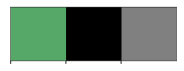

In [24]:
pal = {"control": sns.color_palette()[2], "experimental": "black", "scramble": "gray"}
sns.palplot(pal.values())

In [25]:
# list of promoter overlap hits where no mrnas whose tss is within 1000 bp of the lncrna tsss are expr (>=1 tpm)
# in either hESCs or endo RNA-seq samples
# (found in the "hit_expression" downstream notebook; copy-pasting here to highlight in plot)
promoverlap_noexp_ids = ['RP11-326C3.12-001', 'RP11-402J6.1-002', 'HOXC-AS1-002', 'AC011523.2-001', 'RP4-680D5.8-001']
promoverlap_noexp = promoverlap[promoverlap["transcript_name"].isin(promoverlap_noexp_ids)]
len(promoverlap_noexp)

5

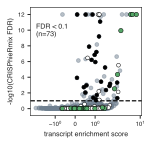

In [26]:
fig = plt.figure(figsize=(2,2))

ax = plt.gca()

ax.scatter(exp["l2fc_diff"], exp["neg_log_FDR"], color="slategray", s=15, alpha=0.5)
ax.scatter(nopromoverlap["l2fc_diff"], nopromoverlap["neg_log_FDR"], color="black", edgecolors="black",
           linewidths=0.5, s=15, alpha=1)
ax.scatter(mrna["l2fc_diff"], mrna["neg_log_FDR"], color="white", s=15, alpha=1, edgecolors="black", linewidths=0.5)
ax.scatter(ctrl["l2fc_diff"], ctrl["neg_log_FDR"], color=pal["control"], s=20, alpha=1, edgecolors="black",
           linewidths=0.5)
ax.scatter(scr["l2fc_diff"], scr["neg_log_FDR"], color="gray", s=15, alpha=0.5)
ax.axhline(y=1, linestyle="dashed", color="black")
ax.set_xlabel("transcript enrichment score")
ax.set_ylabel("-log10(CRISPhieRmix FDR)")
ax.set_xscale('symlog')

# annotate #s
n_sig = len(sig)
n_not_sig = len(not_sig)
ax.text(0.05, 0.85, "FDR < 0.1\n(n=%s)" % (n_sig), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)

fig.savefig("Fig3F.pdf", dpi="figure", bbox_inches="tight")

In [27]:
ctrl[ctrl["FDR"] < 0.1]

,groups,FDR,transcript_name,group_id,ctrl_status,transcript_biotype_status,n_sgRNA,l2fc_diff,neg_log_FDR
3277,EOMES-001;;;NC_000003.12:-:27722322;;;control;...,0.000000e+00,EOMES-001,NC_000003.12:-:27722322,control,protein_coding,6,5.470160,12.000000
3278,EOMES-004;;;NC_000003.12:-:27722707;;;control;...,0.000000e+00,EOMES-004,NC_000003.12:-:27722707,control,protein_coding,6,6.092888,12.000000
3377,FOXA2-002;;;NC_000020.11:-:22584571;;;control;...,1.132523e-10,FOXA2-002,NC_000020.11:-:22584571,control,protein_coding,9,2.897134,9.942135
3415,GATA6-001;;;NC_000018.10:+:22169434;;;control;...,4.454609e-05,GATA6-001,NC_000018.10:+:22169434,control,protein_coding,7,2.338529,4.351190
3463,GSC-001;;;NC_000014.9:-:94770237;;;control;;;p...,2.982147e-03,GSC-001,NC_000014.9:-:94770237,control,protein_coding,3,1.970223,2.525471
9414,SOX17-001;;;NC_000008.11:+:54457934;;;control;...,0.000000e+00,SOX17-001,NC_000008.11:+:54457934,control,protein_coding,7,7.776623,12.000000


## 6. check enrichment of liu (CRiNCL) lncRNAs in our day zero drop-out results

In [28]:
liu_res = pd.read_table(liu_res_f, sep="\t", skiprows=3, names=["tss_id", "score_t12_1", "score_t12_2", "score_t12_av",
                                                                "hit_t12", "score_t18_1", "score_t18_2", 
                                                                "score_t18_av", "hit_t18"])
liu_res.head()

,tss_id,score_t12_1,score_t12_2,score_t12_av,hit_t12,score_t18_1,score_t18_2,score_t18_av,hit_t18
0,LH00001,10.672142,3.846223,6.159411,NaN,17.227574,11.016082,15.913560,lncRNA hit
1,LH00007,1.266395,0.147974,0.239338,NaN,4.214222,0.062564,1.352297,NaN
2,LH00008,0.961004,0.005352,0.108713,NaN,0.025561,0.001773,0.018227,NaN
3,LH00016,0.162637,0.114304,0.212666,NaN,0.424833,0.521515,1.092956,NaN
4,LH00024,2.209663,0.060168,0.428305,NaN,0.597580,0.028017,0.149071,NaN


In [29]:
liu_res.min(axis=0)

tss_id           LH00001
score_t12_1     1.15e-05
score_t12_2            0
score_t12_av    3.59e-06
score_t18_1            0
score_t18_2     2.56e-06
score_t18_av    1.89e-05
dtype: object

In [30]:
liu_hits = list(liu_res[(~pd.isnull(liu_res["hit_t12"])) | (~pd.isnull(liu_res["hit_t18"]))]["tss_id"])
len(liu_hits)

651

In [31]:
liu_tss = pd.read_table(liu_meta_f, sep="\t")
liu_tss.head()

,Gene ID,TSS ID,Transcript ID,gene name
0,LH00001,TSS5,"CUFF.182.5,CUFF.182.7",RP4-669L17.10
1,LH00002,TSS11,ENST00000419160,RP4-669L17.10
2,LH00003,TSS12,ENST00000601814,RP4-669L17.10
3,LH00004,TSS24,CUFF.184.1,RP5-857K21.15
4,LH00005,TSS17,CUFF.182.21,RP5-857K21.15


In [32]:
## subset results to those lncRNAs that are in the liu library
crisphie_liu = crisphie_dz[crisphie_dz["gene_name"].isin(liu_tss["gene name"])]
print(len(crisphie_liu))
print(len(crisphie_liu.gene_name.unique()))

4464
3182


In [33]:
liu_hits_tss = liu_tss[liu_tss["Gene ID"].isin(liu_hits)]
liu_hits_tss.head()

,Gene ID,TSS ID,Transcript ID,gene name
0,LH00001,TSS5,"CUFF.182.5,CUFF.182.7",RP4-669L17.10
84,LH00082,TSS331,P1P2,RP4-635E18.6
89,LH00087,TSS360,CUFF.398.1,RP11-474O21.5
111,LH00109,TSS436,ENST00000562878,RP4-798A10.7
125,LH00123,TSS500,P1P2,RP1-43E13.2


In [34]:
liu_hits_annot = liu_hits_tss[liu_hits_tss["gene name"] != "-"]
print(len(liu_hits_annot))
liu_hits_annot.sample(5)

504


,Gene ID,TSS ID,Transcript ID,gene name
14575,LH14038,TSS89964,P1P2,LINC-NUS1-1
15586,LH15008,TSS96462,ENST00000476560,OR2A1-AS1
293,LH00284,TSS1332,ENST00000606527,RP11-155O18.6
13785,LH13281,TSS84881,CUFF.40690.1,RP11-500C11.3
14320,LH13802,TSS88584,P2,ZSCAN16-AS1


In [35]:
sig_dz = crisphie_dz[crisphie_dz["FDR"] < 0.1]
len(sig_dz)

598

In [36]:
n_mHit_lHit = len(crisphie_liu[(crisphie_liu["gene_name"].isin(sig_dz["gene_name"])) & 
                               (crisphie_liu["gene_name"].isin(liu_hits_tss["gene name"]))]["gene_name"].unique())
n_mHit_lNoHit = len(crisphie_liu[(crisphie_liu["gene_name"].isin(sig_dz["gene_name"])) & 
                                 (~crisphie_liu["gene_name"].isin(liu_hits_tss["gene name"]))]["gene_name"].unique())
n_mNoHit_lHit = len(crisphie_liu[(~crisphie_liu["gene_name"].isin(sig_dz["gene_name"])) & 
                                 (crisphie_liu["gene_name"].isin(liu_hits_tss["gene name"]))]["gene_name"].unique())
n_mNoHit_lNoHit = len(crisphie_liu[(~crisphie_liu["gene_name"].isin(sig_dz["gene_name"])) & 
                                   (~crisphie_liu["gene_name"].isin(liu_hits_tss["gene name"]))]["gene_name"].unique())

print("# genes that are hits in our screen and hits in CRiNCL: %s" % n_mHit_lHit)
print("# genes that are hits in our screen and not hits in CRiNCL: %s" % n_mHit_lNoHit)
print("# genes that are not hits in our screen and hits in CRiNCL: %s" % n_mNoHit_lHit)
print("# genes that are not hits in our screen and not hits in CRiNCL: %s" % n_mNoHit_lNoHit)

# genes that are hits in our screen and hits in CRiNCL: 52
# genes that are hits in our screen and not hits in CRiNCL: 206
# genes that are not hits in our screen and hits in CRiNCL: 176
# genes that are not hits in our screen and not hits in CRiNCL: 2748


In [37]:
stats.fisher_exact([[n_mHit_lHit, n_mHit_lNoHit], [n_mNoHit_lHit, n_mNoHit_lNoHit]])

(3.941306266548985, 5.969669812993291e-13)

In [38]:
plot_dict = {"perc_crincl_hits_in_our_hits": (n_mHit_lHit/(n_mHit_lHit+n_mHit_lNoHit))*100,
             "perc_crincl_hits_in_our_nohits": (n_mNoHit_lHit/(n_mNoHit_lHit+n_mNoHit_lNoHit))*100,
             "perc_our_hits_in_crincl_hits": (n_mHit_lHit/(n_mHit_lHit+n_mNoHit_lHit))*100,
             "perc_our_hits_in_crincl_nohits": (n_mHit_lNoHit/(n_mHit_lNoHit+n_mNoHit_lNoHit))*100}
plot_df = pd.DataFrame.from_dict(plot_dict, orient="index").reset_index()
plot_df

,index,0
0,perc_crincl_hits_in_our_hits,20.155039
1,perc_crincl_hits_in_our_nohits,6.019152
2,perc_our_hits_in_crincl_hits,22.807018
3,perc_our_hits_in_crincl_nohits,6.973595


## 9. write final file(s)

In [39]:
def is_hit(row):
    if row["FDR"] < 0.1:
        return "hit"
    else:
        return "no hit"
    
crisphie_diff["hit_status"] = crisphie_diff.apply(is_hit, axis=1)

In [40]:
supp = crisphie_diff[["group_id", "transcript_name", "ctrl_status", "transcript_biotype_status", "FDR", "l2fc_diff", 
                 "hit_status", "n_sgRNA"]]
supp.columns = ["group_id", "transcript_name", "ctrl_status", "transcript_biotype_status", "CRISPhieRmix_FDR", 
                "effect_size", "hit_status", "n_sgRNA"]
supp = supp.sort_values(by="CRISPhieRmix_FDR")
print(len(supp))
supp.head()

9771


,group_id,transcript_name,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
3278,NC_000003.12:-:27722707,EOMES-004,control,protein_coding,0.0,6.092888,hit,6
9358,NC_000019.10:+:11060127,SMARCA4-014,mRNA,protein_coding,0.0,1.145824,hit,6
676,NC_000023.11:-:11111137,"[RP11-120D5.1-005, RP11-120D5.1-004]",experimental,promoter_overlap,0.0,4.142174,hit,7
8978,NC_000020.11:+:37095770,RP4-621N11.2-001,experimental,promoter_overlap,0.0,0.626713,hit,5
5204,NC_000011.10:+:90223166,RP11-121L10.2-001,experimental,promoter_overlap,0.0,5.297966,hit,8


In [41]:
supp.hit_status.value_counts()

no hit    9698
hit         73
Name: hit_status, dtype: int64

In [42]:
supp.sort_values(by="CRISPhieRmix_FDR", ascending=True).head(10)

,group_id,transcript_name,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
3278,NC_000003.12:-:27722707,EOMES-004,control,protein_coding,0.000000e+00,6.092888,hit,6
9358,NC_000019.10:+:11060127,SMARCA4-014,mRNA,protein_coding,0.000000e+00,1.145824,hit,6
676,NC_000023.11:-:11111137,"[RP11-120D5.1-005, RP11-120D5.1-004]",experimental,promoter_overlap,0.000000e+00,4.142174,hit,7
8978,NC_000020.11:+:37095770,RP4-621N11.2-001,experimental,promoter_overlap,0.000000e+00,0.626713,hit,5
5204,NC_000011.10:+:90223166,RP11-121L10.2-001,experimental,promoter_overlap,0.000000e+00,5.297966,hit,8
9414,NC_000008.11:+:54457934,SOX17-001,control,protein_coding,0.000000e+00,7.776623,hit,7
3277,NC_000003.12:-:27722322,EOMES-001,control,protein_coding,0.000000e+00,5.470160,hit,6
3553,NC_000012.12:-:53999649,HOXC-AS1-002,experimental,promoter_overlap,0.000000e+00,0.797079,hit,8
9464,NC_000005.10:-:173329499,STC2-001,mRNA,protein_coding,3.700743e-17,1.215004,hit,6
1911,NC_000003.12:-:38454682,ACVR2B-AS1-001,experimental,promoter_overlap,1.332268e-16,3.118909,hit,10


In [43]:
supp[supp["transcript_name"].str.contains("RP11-541P9.3")]

,group_id,transcript_name,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
7513,NC_000005.10:-:163256966,RP11-541P9.3-003,experimental,intergenic,6.284444e-10,1.193886,hit,4
7512,NC_000005.10:-:163437288,RP11-541P9.3-001,experimental,promoter_overlap,9.296604e-01,0.669906,no hit,3
7514,NC_000005.10:-:163256986,RP11-541P9.3-004,experimental,intergenic,9.456111e-01,-0.152677,no hit,5


In [44]:
f = "../../../data/02__screen/02__enrichment_data/SuppTable_S3.CRISPhieRmix_results.txt"
supp.to_csv(f, sep="\t", index=False)